<a href="https://colab.research.google.com/github/mitsutaka28/RecSys2022/blob/main/Tokushuku/20220515MatrixFactrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

メモ@20220517\
推薦システム本のコードのコピーでMF\
適当なパラメーターでscore	0.0115程度でだめだめ\
深掘りチューニング等が課題化。暗黙的評価用のMFもあるそうなので試してみたい

In [2]:
#colab_note上で必要
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#import plotly.graph_objects as go
from datetime import datetime
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
"""
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
"""

'\nimport torch\nfrom torch import nn\nfrom torch.utils.data import DataLoader\nfrom torchvision import datasets\nfrom torchvision.transforms import ToTensor, Lambda, Compose\n'

In [6]:
class DataLoader:
    
    def __init__(self, data_path = work_folder):
        self.data_path = data_path
    
    # RawTable取得
    def load_rawtable(self):
        
        ### rawdata
        candidate_items = pd.read_csv( work_folder + "/candidate_items.csv")
        item_features = pd.read_csv( work_folder + "/item_features.csv")
        test_final_sessions = pd.read_csv( work_folder + "/test_final_sessions.csv")
        test_leaderboard_sessions = pd.read_csv( work_folder + "/test_leaderboard_sessions.csv")
        train_purchases = pd.read_csv( work_folder + "/train_purchases.csv")
        train_sessions = pd.read_csv( work_folder + "/train_sessions.csv")
        
        return candidate_items, item_features, test_final_sessions, test_leaderboard_sessions, train_purchases, train_sessions
    
    # RawTable -> 疎行列
    def load_sparsetable(self):
        
        candidate_items, item_features, test_final_sessions, test_leaderboard_sessions, train_purchases, train_sessions = self.load_rawtable()
        
        ### 疎行列作成
        # train_dataのうち，購入itemがcandidate_itemに含まれるsessionを抽出
        candidate_items_flg = candidate_items['item_id'].unique()
        candidate_session_flg = train_purchases[train_purchases['item_id'].isin(candidate_items_flg)]['session_id'].values

        # train_dataのうち購入itemがcandidate_itemに含まれるsession
        train_purchases_cand = train_purchases[train_purchases['session_id'].isin(candidate_session_flg)]
        train_sessions_cand  = train_sessions[train_sessions['session_id'].isin(candidate_session_flg)]

        # train_dataのうち購入itemがcandidate_itemに含まれないsession
        train_purchases_not_cand = train_purchases[~train_purchases['session_id'].isin(candidate_session_flg)]
        train_sessions_not_cand  = train_sessions[~train_sessions['session_id'].isin(candidate_session_flg)]

        # 疎行列のvalue作成
        train_purchases_cand['count'] = 1
        train_sessions_cand['count'] = 1
        train_purchases_not_cand['count'] = 1
        train_sessions_not_cand['count'] = 1
        test_leaderboard_sessions['count'] = 1
        test_final_sessions['count'] = 1
        
        index = 'session_id'
        col = 'item_id'
        val = 'count'
        col_list = item_features['item_id'].unique()

        train_sessions_cand_sparse = self.make_sparse_pivot(train_sessions_cand, index, col, val, col_list = col_list)
        train_purchases_not_cand_sparse = self.make_sparse_pivot(train_purchases_not_cand, index, col, val, col_list = col_list)
        test_leaderboard_sessions_sparse = self.make_sparse_pivot(test_leaderboard_sessions, index, col, val, col_list = col_list)
        test_final_sessions_sparse = self.make_sparse_pivot(test_final_sessions, index, col, val, col_list = col_list)
        
        return train_sessions_cand_sparse, train_purchases_not_cand_sparse, test_leaderboard_sessions_sparse, test_final_sessions_sparse
    
    #参考URL: https://developers.microad.co.jp/entry/2019/05/10/180000
    #疎行列のpivotテーブルを作成
    def make_sparse_pivot(self, df, index= 'session_id', col = 'item_id', val = 'count', index_list = [], col_list = []): 
        if(len(index_list) == 0):
            index_list = df[index].unique()
        if(len(col_list) == 0):
            col_list = df[col].unique()
        index_categorical = pd.api.types.CategoricalDtype(categories=sorted(index_list), ordered=True)
        col_categorical = pd.api.types.CategoricalDtype(categories=sorted(col_list), ordered=True)
        row_num = df[index].astype(index_categorical).cat.codes
        col_num = df[col].astype(col_categorical).cat.codes

        sparse_matrix = csr_matrix((df[val], (row_num, col_num)), \
                               shape=(index_categorical.categories.size, \
                                      col_categorical.categories.size))
        return sparse_matrix
    
    # validationデータ作成(作成中,load_sparsetableをtrain用とtest用に分割してtrain用をsplit_dataに流用する, sparseのindexはどうとる?, )
    def split_data(self, df_session_sparse, test_size = 0.2, seed = 0):
        X_train, X_test = train_test_split(df_session_sparse, test_size = test_size, random_state = seed)
        return X_train, X_test

In [5]:
work_folder = '/content/drive/My Drive/dressipi_recsys2022/'

In [7]:
#データ読み込み
warnings.simplefilter('ignore')
data_loader = DataLoader(data_path = work_folder)
# rawtable（testの購入候補，itemの特徴，test_final, test_lb, train購入item, train）
candidate_items, item_features, test_final_sessions, test_leaderboard_sessions, train_purchases, train_sessions = data_loader.load_rawtable()
# 疎行列(trainのうち，testの購入候補が含まれるsession, trainのうち，testの購入候補が含まれないsession, test_lb, test_final)
train_sessions_cand_sparse, train_purchases_not_cand_sparse, test_leaderboard_sessions_sparse, test_final_sessions_sparse = data_loader.load_sparsetable()

In [148]:
# 因子数
factors = 200
#購入回数の閾値
minimum_num_rating = 20

# バイアス項の使用
use_biase = True
# 学習率
lr_all = 0.01
# エポック数
n_epochs = 50

#見た回数と購入の評価倍率（ratingは　session:閲覧回数、purchase: purchase_rate がrateになる）
purchase_rate = 10

#商品の閲覧回数の上限
thr_look = 5

In [149]:
#購入回数が低いアイテムとcandidate_itemにないアイテムを除外
ranking = train_purchases.groupby('item_id').agg(len).sort_values('session_id', ascending = False).reset_index()
filtered_item = ranking[ranking['session_id'] >= minimum_num_rating]['item_id']
filtered_item = candidate_items[candidate_items['item_id'].isin(filtered_item)]['item_id'].values

Text(0, 0.5, 'itemの件数')

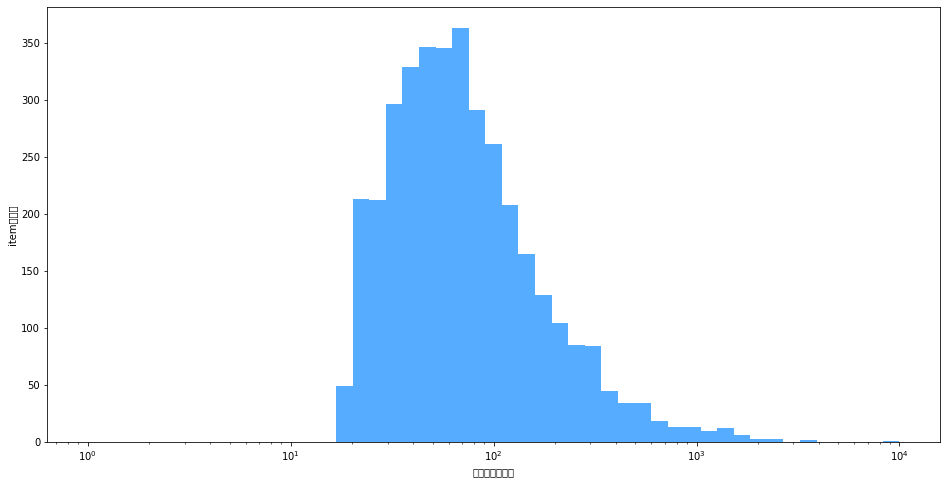

In [151]:
#除外後の購入回数のヒストグラムを確認
df_purchases_counts = train_purchases[train_purchases["item_id"].isin(filtered_item)]["item_id"].value_counts().values
ax = plt.figure(figsize = (16, 8)).add_subplot(111)
ax.hist(x = df_purchases_counts, bins = np.logspace(0, 4, 50), color = 'dodgerblue', alpha = 0.75)
ax.set_xscale('log')
ax.set_xlabel('購入された件数')
ax.set_ylabel("itemの件数")

In [152]:
#ライブラリのインストール
!pip install surprise
from surprise import SVD, Reader
from surprise import Dataset as SurpriseDataset

In [153]:
#閲覧回数と購入でratingを作成
train_sessions_rate = train_sessions.groupby(['session_id','item_id']).agg({'item_id':len}).rename(columns = {'item_id':'rating'}).reset_index()
train_sessions_rate[train_sessions_rate['rating']>=thr_look]['rating'] = thr_look

lb_sessions_rate = test_leaderboard_sessions.groupby(['session_id','item_id']).agg({'item_id':len}).rename(columns = {'item_id':'rating'}).reset_index()
lb_sessions_rate[lb_sessions_rate['rating']>=thr_look]['rating'] = thr_look

train_purchases['rating'] = purchase_rate 

In [156]:
#上記のテーブルを結合してアイテムを絞る
df_train = pd.concat([train_sessions_rate, train_purchases[['session_id', 'item_id', 'rating']], lb_sessions_rate])
df_train = df_train[df_train['item_id'].isin(filtered_item)]

In [157]:
#suprise形式に変換
reader = Reader(rating_scale=(0.5, purchase_rate))
data_train = SurpriseDataset.load_from_df(
    df_train[['session_id','item_id', 'rating']], reader
).build_full_trainset()

In [158]:
#学習
matrix_factorization = SVD(n_factors=factors, n_epochs=n_epochs, lr_all=lr_all, biased=use_biase)
matrix_factorization.fit(data_train)

In [159]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # 各ユーザーごとに、予測されたアイテムを格納する
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # ユーザーごとに、アイテムを予測評価値順に並べ上位n個を格納する
    for uid, user_ratings in top_n.items():
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      #何故かMFの結果にnanが出るのでnullチェックを挟む
      tmp = np.array(user_ratings)[::,0][0:n + 50]
      tmp = tmp[~np.isnan(tmp)]

      top_n[uid] = tmp[:n]

    return top_n

In [172]:
#各sessionで推薦上位のアイテム100件を取得
lb_session_list = test_leaderboard_sessions['session_id'].unique()
candidate_items_list = filtered_item

item_id = []
session_id = []
rank = []
count = 0

for i,tmp_session_id  in enumerate(lb_session_list):
  #for文のカウント,50000で終わり
  if(count%1000 == 0):
    print(count)
  count += 1

  items_in_sessions = lb_sessions_rate[lb_sessions_rate['session_id'] == tmp_session_id]['item_id'].values
  tmp_item_list = candidate_items[candidate_items.isin(items_in_sessions) == False]['item_id'].values
  item_len = len(tmp_item_list)

  session_ave = np.average(lb_sessions_rate[lb_sessions_rate['session_id'] == tmp_session_id]['rating'])

  session_id_tile = np.array([tmp_session_id for i in range(item_len)])
  session_ave_tile = np.array([session_ave for i in range(item_len)])

  tmp_test = np.vstack([session_id_tile, tmp_item_list,  session_ave_tile]).T
  tmp_test = tuple(map(tuple, tmp_test))

  predictions = matrix_factorization.test(tmp_test)
  pred_user2items = get_top_n(predictions, n=100)

  prob_top100_item_id = pred_user2items[tmp_session_id]
  item_id = np.concatenate([item_id,prob_top100_item_id])

  temp = np.array([tmp_session_id for i in range(len(prob_top100_item_id))])
  session_id = np.concatenate([session_id,temp])

  temp = np.array([i + 1 for i in range(len(prob_top100_item_id))])
  rank = np.concatenate([rank,temp])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [173]:
df_sub_lb = pd.DataFrame(np.vstack([session_id, item_id, rank]).T, columns=['session_id', 'item_id', 'rank'])
df_sub_lb = df_sub_lb.astype('int')#intに明示的に変換しないと通らない

In [177]:
#保存
file_name = "submit20220517_MF_v2"
df_sub_lb.to_csv(work_folder + file_name + ".csv", index=False)

以下はゴミ

In [163]:
n = 10
top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)

user_ratings.sort(key=lambda x: x[1], reverse=True)
user_ratings

[(8060.0, 6.30076646711704),
 (1840.0, 5.411253652538331),
 (14343.0, 5.207562148557477),
 (11923.0, 5.201301614724969),
 (18093.0, 5.165073964888284),
 (27555.0, 4.952534012370961),
 (24222.0, 4.941498213848936),
 (24971.0, 4.928462665839428),
 (4193.0, 4.925827296767088),
 (11399.0, 4.869181404568719),
 (19944.0, 4.821013810947031),
 (22175.0, 4.765037037383736),
 (28078.0, 4.758865990281246),
 (18147.0, 4.738667324678535),
 (26249.0, 4.720787383355663),
 (1637.0, 4.674313876250409),
 (21781.0, 4.667792101971874),
 (20721.0, 4.626601951282489),
 (26538.0, 4.5851487685291135),
 (12222.0, 4.579743556665829),
 (26.0, 4.5580089091654905),
 (27416.0, 4.5474031341638455),
 (13994.0, 4.546269558670454),
 (23789.0, 4.543851735456588),
 (27884.0, 4.541344694371784),
 (25865.0, 4.53418232393569),
 (5931.0, 4.532741727586976),
 (14392.0, 4.4990204312115525),
 (9284.0, 4.48828752095137),
 (6178.0, 4.462855377873888),
 (22209.0, 4.456253461705712),
 (16097.0, 4.452829810533167),
 (12540.0, 4.4475

In [ ]:
ranking[ranking['item_id']==15998]

,item_id,session_id,date
667,15998,204,204


In [ ]:
candidate_items[candidate_items['item_id'] == 8814]

,item_id
1596,8814


In [170]:
df_sub_lb[df_sub_lb['rank'] ==3]

,session_id,item_id,rank
2,26,1840,3
102,200,4167,3
202,205,26956,3
302,495,11399,3
402,521,4167,3
...,...,...,...
680302,603171,5353,3
680402,603236,1840,3
680502,603291,11399,3
680602,603292,11399,3


In [175]:
df_sub_lb[df_sub_lb['item_id'] ==8060]

,session_id,item_id,rank
0,26,8060,1
200,205,8060,1
300,495,8060,1
400,521,8060,1
500,587,8060,1
...,...,...,...
4999500,4439446,8060,1
4999600,4439458,8060,1
4999700,4439550,8060,1
4999800,4439653,8060,1


In [ ]:
import warnings
warnings.simplefilter('ignore')

num_n_neighbors = 10000

#予測：雑実装のため60分くらいかかる、、、
df_sub_lb = pd.DataFrame(columns=['session_id', 'item_id', 'rank'])
item_id = []
session_id = []
rank = []
count = 0
for i,s  in enumerate(unique_session_lb):
  #for文のカウント,50000で終わり
  if(count%1000 == 0):
    print(count)
  count += 1

  distance, indice = rec_model.kneighbors(lb_session_sparse.getrow(i).toarray().flatten().reshape(1,-1),n_neighbors=num_n_neighbors)
  df_distance = pd.DataFrame(np.array([df_train_purchases.loc[session_id_list[indice].flatten()].item_id.values, 1 - distance[0]]).T, columns=['candidate_item_id', 'distance'])

  session_item_list = df_test_leaderboard_sessions[df_test_leaderboard_sessions['session_id']==s].item_id.values
  df_distance = df_distance[df_distance['candidate_item_id'].isin(session_item_list)==False]

  prob_top100_item_id=df_distance.groupby('candidate_item_id').sum().sort_values('distance', ascending = 0).index.astype('int').values[0:100]

  item_id = np.concatenate([item_id,prob_top100_item_id])

  temp = np.array([s for i in range(len(prob_top100_item_id))])
  session_id = np.concatenate([session_id,temp])

  temp = np.array([i + 1 for i in range(len(prob_top100_item_id))])
  rank = np.concatenate([rank,temp])


In [ ]:
df_sub_lb = pd.DataFrame(np.vstack([session_id, item_id, rank]).T, columns=['session_id', 'item_id', 'rank'])
df_sub_lb = df_sub_lb.astype('int')#intに明示的に変換しないと通らない

In [ ]:
warnings.simplefilter('ignore')
recommender = Recommender()
#df_train_sparse...trainの疎行列
#df_train_purchases...trainの購入データ
#item_features...(raw_table)
#n_neighbors_fit...学習用の近傍点
#df_test...testデータ
#df_test_sparse...testの疎行列
#n_neighbors_show...重みづけ計算
result_KNN = recommender.KNN(df_train_sparse = train_sessions_cand_sparse, df_train_purchases = train_purchases, \
            item_features = item_features, \
            n_neighbors_fit = 10, df_test = test_leaderboard_sessions,  \
            df_test_sparse = test_leaderboard_sessions_sparse, n_neighbors_show = 10000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


KeyboardInterrupt: ignored

In [ ]:
#参考URL: https://developers.microad.co.jp/entry/2019/05/10/180000
def make_sparse_pivot(df, index, col, val, index_list = [], col_list = []): 
  if(len(index_list) == 0):
    index_list = df[index].unique()
  if(len(col_list) == 0):
    col_list = df[col].unique()
  index_categorical = pd.api.types.CategoricalDtype(categories=sorted(index_list), ordered=True)
  col_categorical = pd.api.types.CategoricalDtype(categories=sorted(col_list), ordered=True)
  row_num = df[index].astype(index_categorical).cat.codes
  col_num = df[col].astype(col_categorical).cat.codes
  
  sparse_matrix = csr_matrix((df[val], (row_num, col_num)), \
                           shape=(index_categorical.categories.size, \
                                  col_categorical.categories.size))
  return sparse_matrix

In [ ]:
folder_path = '/content/drive/My Drive/dressipi_recsys2022/'
file_name_list = ["candidate_items.csv", "item_features.csv", "test_final_sessions.csv", "test_leaderboard_sessions.csv", "train_purchases.csv", "train_sessions.csv"]
df_candidate_items = pd.read_csv(folder_path + file_name_list[0])
df_item_features = pd.read_csv(folder_path + file_name_list[1])
df_test_final_sessions = pd.read_csv(folder_path + file_name_list[2])
df_test_leaderboard_sessions = pd.read_csv(folder_path + file_name_list[3])
df_train_purchases = pd.read_csv(folder_path + file_name_list[4])
df_train_sessions = pd.read_csv(folder_path + file_name_list[5])

In [ ]:
df_train_sessions['count'] = 1.0
df_test_leaderboard_sessions['count'] = 1.0

In [ ]:
candidate_items = df_candidate_items['item_id'].unique()
candidate_session_list = df_train_purchases[df_train_purchases['item_id'].isin(candidate_items)]['session_id'].values

In [ ]:
df_train_purchases = df_train_purchases[df_train_purchases['session_id'].isin(candidate_session_list)]
df_train_sessions = df_train_sessions[df_train_sessions['session_id'].isin(candidate_session_list)]

In [ ]:
df_item_features['feature_multi'] = df_item_features['feature_category_id'].astype('str')+'_'+df_item_features['feature_value_id'].astype('str')

In [ ]:
df_train_sessions = pd.merge(df_train_sessions, df_item_features, how = 'left', on = 'item_id')
df_test_leaderboard_sessions = pd.merge(df_test_leaderboard_sessions, df_item_features, how = 'left', on = 'item_id')

In [ ]:
df_train = df_train_sessions
unique_item_id_list = df_item_features['item_id'].unique()

In [ ]:
index = 'session_id'
col = 'feature_multi'
val = 'count'
col_list = df_item_features['feature_multi'].unique()

train_sparse = make_sparse_pivot(df_train_sessions, index, col, val, col_list = col_list)

In [ ]:
#KNNのインスタンス化。評価方法をコサイン類似度に設定。bruteは総当り方式。
rec = NearestNeighbors(n_neighbors=10,algorithm= "brute", metric= "cosine")
# KNNで訓練
rec_model = rec.fit(train_sparse)

In [ ]:
lb_session_sparse = make_sparse_pivot(df_test_leaderboard_sessions, index, col, val, col_list = col_list)
unique_session_lb = df_test_leaderboard_sessions['session_id'].unique()

In [ ]:
df_train_purchases = df_train_purchases.set_index('session_id')
session_id_list = df_train_purchases.index

In [ ]:
import warnings
warnings.simplefilter('ignore')

num_n_neighbors = 10000

#予測：雑実装のため60分くらいかかる、、、
df_sub_lb = pd.DataFrame(columns=['session_id', 'item_id', 'rank'])
item_id = []
session_id = []
rank = []
count = 0
for i,s  in enumerate(unique_session_lb):
  #for文のカウント,50000で終わり
  if(count%1000 == 0):
    print(count)
  count += 1

  distance, indice = rec_model.kneighbors(lb_session_sparse.getrow(i).toarray().flatten().reshape(1,-1),n_neighbors=num_n_neighbors)
  df_distance = pd.DataFrame(np.array([df_train_purchases.loc[session_id_list[indice].flatten()].item_id.values, 1 - distance[0]]).T, columns=['candidate_item_id', 'distance'])

  session_item_list = df_test_leaderboard_sessions[df_test_leaderboard_sessions['session_id']==s].item_id.values
  df_distance = df_distance[df_distance['candidate_item_id'].isin(session_item_list)==False]

  prob_top100_item_id=df_distance.groupby('candidate_item_id').sum().sort_values('distance', ascending = 0).index.astype('int').values[0:100]

  item_id = np.concatenate([item_id,prob_top100_item_id])

  temp = np.array([s for i in range(len(prob_top100_item_id))])
  session_id = np.concatenate([session_id,temp])

  temp = np.array([i + 1 for i in range(len(prob_top100_item_id))])
  rank = np.concatenate([rank,temp])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [ ]:
df_sub_lb = pd.DataFrame(np.vstack([session_id, item_id, rank]).T, columns=['session_id', 'item_id', 'rank'])
df_sub_lb = df_sub_lb.astype('int')#intに明示的に変換しないと通らない

In [ ]:
#保存
file_name = "submit20220425_cos_dist4"
df_sub_lb.to_csv(folder_path + file_name + ".csv", index=False)